In [16]:
# Database
import sqlite3

# Machine learning
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split

# NLP
import spacy

# Plots
import matplotlib.pyplot as plt

# Own fns
import preprocessing
import model_utils as model_utils


# 0. Fetch data from db

In [2]:
con = sqlite3.connect("../../db/db_analytic.sqlite")

cur = con.cursor()

In [3]:
# TODO: Use sqlutils.get_sql_statement()
with open("../../db/sql/select_all_text.sql") as sql_file:
    sql = sql_file.read()
    sql_file.close()

cur.execute(sql)

'''
Response format: list[(text, category)]
'''
response = cur.fetchall()

In [4]:
data_dict = {}
'''
Format: {[category]: list[page_text_content]}
'''

for page in response:
    text = page[0]
    category = page[1]

    if category is None:
        continue

    if category not in list(data_dict.keys()):
        data_dict[category] = [text]
    else :
        data_dict[category].append(text)

print(len(data_dict[0]))

210


# 1. Cleaning

In [5]:
cleaned_data_dict = {}
nlp = spacy.load("fr_core_news_lg")

for category in list(data_dict.keys()):
    cleaned_data_dict[category] = []

for category in list(data_dict.keys()):
    for text_content in data_dict[category]:
        cleaned_text = preprocessing.full_cleaning(text_content, nlp)

        cleaned_data_dict[category].append(cleaned_text)

print(cleaned_data_dict)

{3: ['entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant utilisation ref eco part recycl

# 2. Create a vocabulary

In [6]:
# String containing all the words
all_text = ""

for category in list(cleaned_data_dict.keys()):
    temp_text = " ".join(cleaned_data_dict[category])
    print(temp_text)

    if category == list(cleaned_data_dict.keys())[0]:
        all_text += temp_text
    else:
        all_text += " " + temp_text

# TODO: Fix "'" should not be in the vocabulary ! Check preprocessing.clean_text
vocabulary = np.unique(all_text.split(" "))
print(list(vocabulary))
print(len(list(vocabulary)))

entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant utilisation ref eco part recyclage ry

In [7]:
# Save the vocabulary

with open("./vocab.txt", "w") as vocabulary_file:
    for token in list(vocabulary):
        if token == list(vocabulary)[-1]:
            vocabulary_file.write(token)
        else:
            vocabulary_file.write(token+"|")
    
    vocabulary_file.close()

# 3. Feature extraction (BOW)

In [8]:
X = []
y = []

for category in list(cleaned_data_dict.keys()):
    for text in cleaned_data_dict[category]:
        X.append(preprocessing.get_bags_of_words_vector(text, vocabulary))
        y.append(int(category)) # category should be integer from db

print(len(X))
print(len(y))

1377
1377


# 4. Model

In [9]:
class PageClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=128, dtype=torch.float32),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output_features, dtype=torch.float32),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# 5. Training

In [10]:
# TODO: Put in utils file
def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(input=y_true, other=y_pred).sum().item()
    )  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc

In [11]:
# TODO: Put in utils file
def display_training_metrics(
    epochs: int,
    loss_history: list[float],
    test_loss_history: list[float],
    acc_history: list[float],
    test_acc_history: list[float],
):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Training loss")
    plt.plot(range(epochs), test_loss_history, label="Testing loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_history, label="Training acc")
    plt.plot(range(epochs), test_acc_history, label="Testing acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [12]:
def training_loop(PageClassifier, X, y):
    loss_history, acc_history, val_loss_history, val_acc_history = [], [], [], []

    # Init model
    torch.manual_seed(42)
    # ! +1 is a dirty fix of missing category due to bug during labeling (sport and multimedia categories merged)
    model = PageClassifier(input_features=len(X[0]), output_features=len(list(set(y)))+1) # ! +1 is to remove !!!! 

    loss_fn = nn.CrossEntropyLoss() # ! Use BCELoss for multi-label classification !
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Prepare data
    X = torch.tensor(X).type(torch.float32)
    y = torch.tensor(y).type(torch.long)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 10

    for epoch in range(epochs):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        loss_history.append(loss.cpu().detach().numpy())
        acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Validation
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_val_logits = model(X_val)
            y_val_pred = torch.softmax(y_val_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            val_loss = loss_fn(y_val_logits, y_val)
            val_acc = accuracy_fn(y_pred=y_val_pred, y_true=y_val)

            # 2.1 Save metrics
            val_loss_history.append(val_loss.cpu().detach().numpy())
            val_acc_history.append(val_acc)

        # Print out what's happening
        # if epoch % 25 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {val_loss:.5f}, Test Acc: {val_acc:.2f}%"
        )
    display_training_metrics(
        epochs, loss_history, val_loss_history, acc_history, val_acc_history
    )
    return model

In [13]:
print(set(y))
print(len(list(set(y))))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16


Epoch: 0 | Loss: 2.83325, Acc: 10.08% | Test Loss: 1.80709, Test Acc: 68.48%
Epoch: 1 | Loss: 1.63680, Acc: 82.65% | Test Loss: 1.25099, Test Acc: 70.65%
Epoch: 2 | Loss: 0.94139, Acc: 86.47% | Test Loss: 1.00210, Test Acc: 76.45%
Epoch: 3 | Loss: 0.58421, Acc: 91.92% | Test Loss: 0.84758, Test Acc: 81.88%
Epoch: 4 | Loss: 0.36271, Acc: 95.46% | Test Loss: 0.77001, Test Acc: 83.33%
Epoch: 5 | Loss: 0.22670, Acc: 98.00% | Test Loss: 0.73633, Test Acc: 84.78%
Epoch: 6 | Loss: 0.14281, Acc: 99.00% | Test Loss: 0.72033, Test Acc: 85.51%
Epoch: 7 | Loss: 0.08924, Acc: 99.27% | Test Loss: 0.71583, Test Acc: 86.96%
Epoch: 8 | Loss: 0.05726, Acc: 99.55% | Test Loss: 0.72760, Test Acc: 88.41%
Epoch: 9 | Loss: 0.03722, Acc: 99.91% | Test Loss: 0.75118, Test Acc: 89.13%


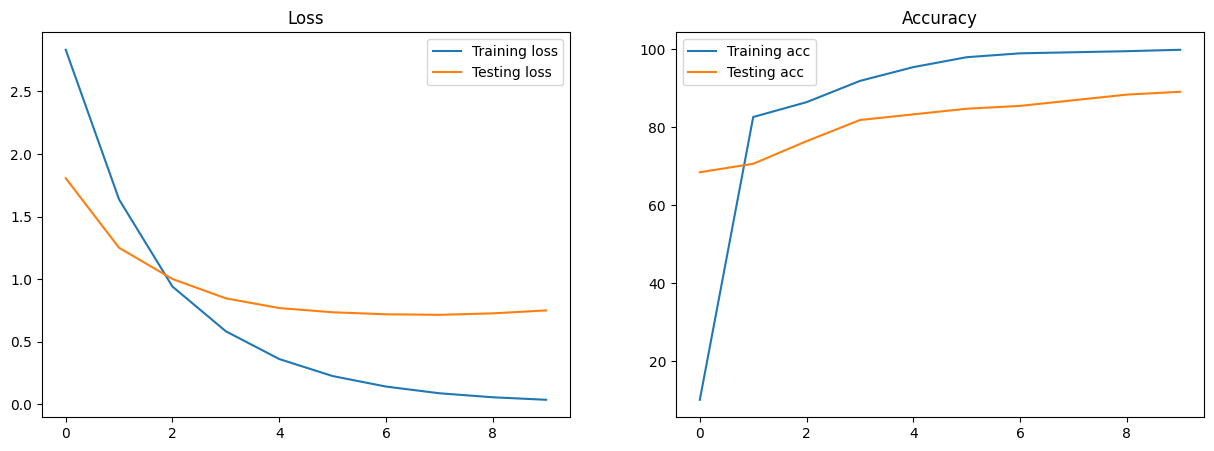

In [14]:
model = training_loop(model_utils.PageClassifier, X, y)

# 6. Save the model

In [15]:
torch.save(model.state_dict(), "./model_weight.pth")

# 7. Prediction

In [16]:
# def predict(model, input: list[int], label_mapping: dict[str]):
#     model.eval()

#     with torch.inference_mode():
#         X = torch.tensor([input]).type(torch.float32)
#         y_logits = model(X)
#         y_softmax = torch.softmax(y_logits, dim=1)
#         y_pred = y_softmax.argmax(dim=1)
        
#         result = y_softmax.detach().numpy()
#         class_prediction = label_mapping[y_pred.detach().numpy()[0]]

#         print("result", result)
#         print("class_prediction =>", class_prediction)

In [18]:
# TODO: Use real test data
input = preprocessing.pipeline_from_raw_text_to_vectors(
    data_dict[1][-1], nlp, vocabulary
)
print(input)
model_utils.predict(model, input)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1

TODO:
- Try auto-sklearn
- Try lazy predict
- Create model.py (with pytorch)